In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle
import os
import gym
import warnings
import torch

from IPython.display import display, clear_output

from cryoenv.mqtt import SoftActorCritic, ReturnTracker, ReplayBuffer, check, subscribe, publish, connect_mqtt, HistoryWriter
from cryoenv.envs import CryoEnvSigWrapper

from mqtt_protocol import *

In [2]:
np.random.seed(rseed)

In [3]:
torch.cuda.is_available()

False

In [4]:
warnings.simplefilter('ignore')

In [5]:
env = gym.make('cryoenv:cryoenv-sig-v0',
                   omega=omega,
                   sample_pars=False,
                   pars={'store_raw': False,
                         'max_buffer_len': buffer_size,
                         'tpa_queue': tpa_queue,
                         'pileup_prob': pileup_prob,
                         'xi': np.array([xi]),
                         'tau': np.array([tau]),},
               render_mode='human',
                   )

In [6]:
state, info = env.reset()
action = env.action_space.sample()

In [7]:
buffer = ReplayBuffer(buffer_size=buffer_size, input_shape=(env.observation_space.shape[0],), n_actions=env.action_space.shape[0], memmap_loc=path_buffer)

writer = HistoryWriter()

agent = SoftActorCritic(env, lr=lr, gamma=gamma, batch_size=batch_size, learning_starts=learning_starts, gradient_steps=gradient_steps, buffer_size=buffer_size, buffer=buffer, 
                        device='cuda' if torch.cuda.is_available() else 'cpu')
agent.save(path_models)

In [8]:
mtime = os.path.getmtime(path_buffer + 'state_memory.npy'.format(channel))
print(mtime)

1675681119.0306804


In [9]:
# we can access the buffer with read rights
steps_counter = 0
while True:
    clear_output(wait=True)
    
    # train only if buffer changed
    current_mtime = os.path.getmtime(path_buffer + 'state_memory.npy'.format(channel))
    if current_mtime > mtime:
        print('new data! buffer total is: {}'.format(agent.buffer.buffer_total))
        if agent.buffer.buffer_total > agent.learning_starts:
            print('train ...')
            for j in range(agent.gradient_steps):
                update_target_value = True if agent.buffer.buffer_total % agent.target_update_interval == 0 else False
                agent._learn_step(update_target_value=update_target_value, writer=writer)
                        
            steps_counter += agent.gradient_steps
            agent.save(path_models)
    mtime = current_mtime
    greedy_action, greedy_likelihood = agent.predict(np.array([0,0,0,0]), greedy=True)
    print('greedy action is: {}, with likelihood: {}'.format(greedy_action, np.exp(greedy_likelihood)))
    print('steps trained: {}, buffer last modified: {}'.format(steps_counter, mtime))    
    time.sleep(.5)

new data! buffer total is: [144]
train ...


KeyboardInterrupt: 

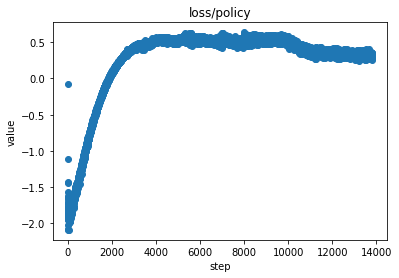

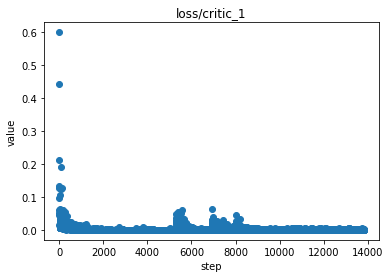

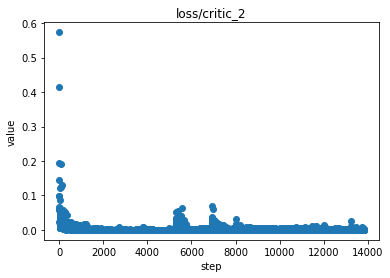

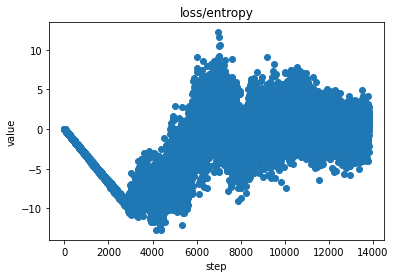

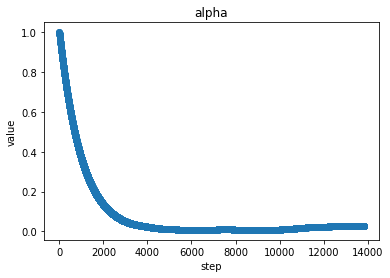

In [10]:
for key in writer.history.keys():
    writer.plot(key)